# IR Project 
# TweetQuake
<img src="img/TwitterMap.png" alt="Drawing" style="width: 475px;float:left; margin-top: 30px" title = "Twitter Map"/>
<img src="img/EarthQuakeMap.png" alt="Drawing" style="width: 475px;float:right" title = "Earthquake Map"/>
<img src="img/EarthQuakeTweet.png" alt="Drawing" style="width: 600px;" title = "Earthquake Tweet Frequency"/>

C:\Users\Aman Mishra\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Aman Mishra\Anaconda2\lib\site-packages\ipykernel\__main__.py:39: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
C:\Users\Aman Mishra\Anaconda2\lib\site-packages\ipykernel\__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Aman Mishra\Anaconda2\lib\site-packages\ipykernel\__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

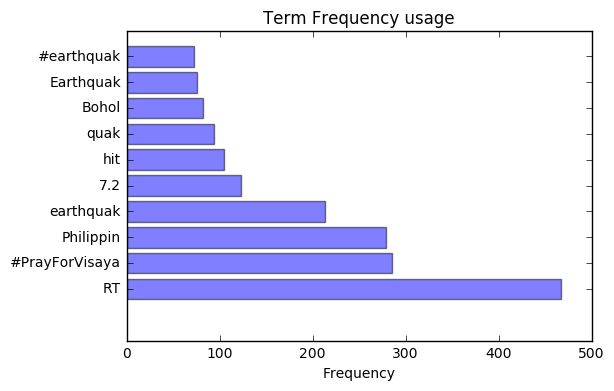

,Tweet_ID,Tweet_Text,Info,nostopword,stem,feature_a,feature_b,feature_c
0,389654490653396992,RT @mariexplorer: Good morning #cebu #sea #par...,0,RT @mariexplorer: Good morning #cebu #sea #pa...,RT @mariexplorer: Good morn #cebu #sea #parad...,"10 words, the -1 word","RT,@mariexplorer,Good,morning,cebu,sea,paradis...",","
1,389896900444319744,Where is Liloan Central Field and how do we ge...,0,Where Liloan Central Field get there? What la...,Where Liloan Central Field get there? What la...,"19 words, the -1 word","Where,is,Liloan,Central,Field,and,how,do,we,ge...",","
2,389908166353231872,"Earthquake in Iloilo, Philippines! My head's a...",1,"Earthquake Iloilo, Philippines! My head's ach...","Earthquak Iloilo, Philippines! My head' aching.","7 words, the 0 word","Earthquake,in,Iloilo,Philippines,My,head's,aching",", in"
3,389909609190006784,RT @LastQuake: NEW: Felt #earthquake M7.0 - Bo...,1,RT @LastQuake: NEW: Felt #earthquake M7.0 - B...,RT @LastQuake: NEW: Felt #earthquak M7.0 - Bo...,"19 words, the 4 word","RT,@LastQuake,NEW,Felt,earthquake,M70,,Bohol,P...","Felt, M7.0"
4,389910137676107776,"RT @NewEarthquake: 7.2 earthquake, 2km S of Nu...",1,"RT @NewEarthquake: 7.2 earthquake, 2km S Nuev...","RT @NewEarthquake: 7.2 earthquake, 2km S Nuev...","22 words, the 1 word","RT,@NewEarthquake,72,earthquake,2km,S,of,Nueva...","RT, 7.2"
5,389910670361100288,RT @gmanews: JUST IN: Magnitude 7.2 earthquake...,1,RT @gmanews: JUST IN: Magnitude 7.2 earthquak...,RT @gmanews: JUST IN: Magnitud 7.2 earthquake...,"20 words, the 6 word","RT,@gmanews,JUST,IN,Magnitude,72,earthquake,2k...","7.2, 2km"
6,389911173665001472,"RT @NewEarthquake: 7.2 earthquake, 2km S of Nu...",1,"RT @NewEarthquake: 7.2 earthquake, 2km S Nuev...","RT @NewEarthquake: 7.2 earthquake, 2km S Nuev...","22 words, the 1 word","RT,@NewEarthquake,72,earthquake,2km,S,of,Nueva...","RT, 7.2"
7,389911358214393856,RT @gmanews: JUST IN: Magnitude 7.2 earthquake...,1,RT @gmanews: JUST IN: Magnitude 7.2 earthquak...,RT @gmanews: JUST IN: Magnitud 7.2 earthquake...,"20 words, the 6 word","RT,@gmanews,JUST,IN,Magnitude,72,earthquake,2k...","7.2, 2km"
8,389911794442964992,RT @BreakingNews: 7.2 earthquake recorded in t...,1,RT @BreakingNews: 7.2 earthquake recorded Phi...,RT @BreakingNews: 7.2 earthquak record Philip...,"13 words, the 3 word","RT,@BreakingNews,72,earthquake,recorded,in,the...","7.2, recorded"
9,389911937040932864,"RT @NewEarthquake: 7.2 earthquake, 2km S of Nu...",1,"RT @NewEarthquake: 7.2 earthquake, 2km S Nuev...","RT @NewEarthquake: 7.2 earthquake, 2km S Nuev...","22 words, the 1 word","RT,@NewEarthquake,72,earthquake,2km,S,of,Nueva...","RT, 7.2"


In [4]:

import re
import csv
import nltk
import operator
# nltk.download()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from nltk.stem.porter import PorterStemmer
%matplotlib inline

def get_data(filename):
    df = pd.read_csv(filename)
    return df
def length(df):
    return len(df['Tweet_Text'])


data = get_data('2013_Bohol_earthquake-tweets_labeled.csv')
data['Info'] = 1
data.Info[('Not related' == data.Informativeness)] = 0
# data.head()
X = data[['Tweet_ID','Tweet_Text','Info']]
y = data.Info
porter_stemmer = PorterStemmer()

# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
wordmap = defaultdict(int)

def Stopword(tweet):
    nostop = str()
    for word in tweet:
        #word = word.decode('utf-8')
        if word not in stopwords: nostop+= " " + word
    return nostop

def remove_stopword (X):
    X['nostopword'] = X.Tweet_Text.str.split().apply(Stopword)
    return X

def Porter_Stem(tweet):
    stemmed_word = str()
    for word in tweet:
        word = word.decode('utf-8')
        stemmed_word += " " + (porter_stemmer.stem(word))
    return stemmed_word
            
def stemming (X):
    X['stem'] = X.nostopword.str.split().apply(Porter_Stem)
    return X

def update_wordmap(tweet):
    #update wordmap
    for word in tweet:
        wordmap[word]+=1

def term_frequency_plot(X):
    #Plot a graph for term frequency in tweets
    X.stem.str.split().apply(update_wordmap)
    sorted_x = sorted(wordmap.items(), key=operator.itemgetter(1), reverse = True)
    objects = list()
    freq = list()
    for i in range(10):
        objects.append(sorted_x[i][0])
        freq.append(sorted_x[i][1])

    x_pos = np.arange(len(objects))
    plt.barh(x_pos, freq, align='center', alpha=0.5)
    plt.xlabel("Frequency")
    plt.yticks(x_pos, objects)
    plt.title('Term Frequency usage')
    plt.show()
    
# Feature Extraction
# X['count'] = X.Tweet_Text.str.split(' ').apply(len)#.value_counts()
# X['has_earthquake'] = X.Tweet_Text.str.contains('earthquake').apply(int)
def Feature_extraction_A(X):
    X['temp_1'] = X.Tweet_Text.str.split(' ').apply(len)
    X['temp_2'] = X.Tweet_Text.str.split().apply(find_position)
    X['feature_a'] = X.temp_1.astype(str) + ' words, the ' + X.temp_2.astype(str) + ' word'
    X = X.drop('temp_1', axis=1)
    X = X.drop('temp_2', axis=1)
    return X

def Feature_extraction_B(X):
    X['feature_b'] = X.Tweet_Text.str.split().apply(remove_punc)
    return X

def Feature_extraction_C(X):
    X['feature_c'] = X.Tweet_Text.str.split().apply(find_before_after_query_word)
    return X

def remove_punc(value):
    punctuation_marks = re.compile(r'[.?!,":;#-]')
    words = []
    for each in value:
        words.append(punctuation_marks.sub('',each))
    return ','.join(words)

def find_position(val):
    for i in range(len(val)):
        if val[i].lower().find('earthquake') != -1:
            return i
    return -1

def find_before_after_query_word(val):
    for i in range(len(val)):
        if val[i].lower().find('earthquake') != -1:
            if i == 0 and len(val)>1:
                return ', '+val[i+1]
            elif i == len(val)-1 and len(val)>1:
                return val[i-1]+', '
            else:
                return val[i-1]+', '+val[i+1]
    return ', '
    
# X['position'] = X.Tweet_Text.str.split().apply(find_position)
# X['before_query1'] = 0
# X.before_query1[X.position > 0] = X.position - 1
X = remove_stopword(X)
X = stemming (X)
term_frequency_plot(X)
X = Feature_extraction_A(X)
X = Feature_extraction_B(X)
X = Feature_extraction_C(X)
X



import twitter, json
api = twitter.Api(consumer_key='4j8Uk7Hea3pdgEuJ6nkvqvVYO',
                  consumer_secret='VU4nTJFz4KQSr66Q1MH7snV0BFEkkeL8sOnu5qGSfzU9poUSU1',
                  access_token_key='44338623-psdoVV5cnUnS9TN0fgrtt4KoMfwxXGfevzS5CllRu',
                  access_token_secret='VKioM8alAKMPTlE1BauuzLC1SLtXbpDWZZ6qEDPi8xz3F')
# results = api.GetSearch(
#     raw_query="q=earthquake%20&result_type=recent&since=2016-07-19&count=10&lang=en")
# for each in results:
# #     print(json.dumps(each, indent=2))
#     print each

# Find tweets using tweet ID
res = api.GetStatus(389949367009808384)

# Code to get the new data with Location and Created date
# def find_created_at(id):
#     try:
#         res = api.GetStatus(id)
#         return res.created_at
#     except:
#         return ''
# X['created_at'] = X.Tweet_ID.astype(int).apply(find_created_at)
# def find_location(id):
#     try:
#         return api.GetStatus(id).user.location
#     except:
#         return ''
# X['location'] = X.Tweet_ID.astype(int).apply(find_location)
# X.to_csv('new_data.csv', sep=',',encoding='utf-8')



## Integration of Twitter API
Keys are for reference 
We can get new data set using this
or modify the old data set to get some new information

In [ ]:
import twitter, json
api = twitter.Api(consumer_key='4j8Uk7Hea3pdgEuJ6nkvqvVYO',
                  consumer_secret='VU4nTJFz4KQSr66Q1MH7snV0BFEkkeL8sOnu5qGSfzU9poUSU1',
                  access_token_key='44338623-psdoVV5cnUnS9TN0fgrtt4KoMfwxXGfevzS5CllRu',
                  access_token_secret='VKioM8alAKMPTlE1BauuzLC1SLtXbpDWZZ6qEDPi8xz3F')
# results = api.GetSearch(
#     raw_query="q=earthquake%20&result_type=recent&since=2016-07-19&count=10&lang=en")
# for each in results:
# #     print(json.dumps(each, indent=2))
#     print each

# Find tweets using tweet ID
res = api.GetStatus(389949367009808384)

# Code to get the new data with Location and Created date
# def find_created_at(id):
#     try:
#         res = api.GetStatus(id)
#         return res.created_at
#     except:
#         return ''
# X['created_at'] = X.Tweet_ID.astype(int).apply(find_created_at)
# def find_location(id):
#     try:
#         return api.GetStatus(id).user.location
#     except:
#         return ''
# X['location'] = X.Tweet_ID.astype(int).apply(find_location)
# X.to_csv('new_data.csv', sep=',',encoding='utf-8')
# abc
# abcd